In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ast
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import normalize
from keras.preprocessing import image
from time import time
from scipy.spatial.distance import cosine, euclidean, hamming

# Data Extraction

In [3]:
recipe = pd.read_csv('core-data_recipe.csv')
print(recipe.shape)
print(recipe.isnull().sum())
recipe.head()

,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name..."
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'..."
2,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
3,245714,Potato Bacon Pizza,https://images.media-allrecipes.com/userphotos...,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
4,218545,Latin-Inspired Spicy Cream Chicken Stew,https://images.media-allrecipes.com/userphotos...,skinless boneless chicken breast halves^diced ...,{'directions': u'Prep\n10 m\nCook\n8 h 15 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name..."


# Reduce size of training set

In [5]:

def reduce_train_csv(file):
    df = pd.read_csv(file)
    # Group by 'recipe_id' and filter groups with more than 3 rows
    df = df.groupby('recipe_id').filter(lambda x: len(x) > 3)
    df_sample = df.head(200000)
    display(df_sample.head())
    return df_sample

def filter_test_set(train_df, test_file):
    test_df = pd.read_csv(test_file)
    train_users = train_df['user_id'].unique()
    train_recipes = train_df['recipe_id'].unique()
    # Filter the test set to only include users and recipes that are also in the training set
    test_df = test_df[test_df['user_id'].isin(train_users) & test_df['recipe_id'].isin(train_recipes)]
    # Randomly sample 10,000 rows from the test set
    test_df = test_df.sample(n=10000, random_state=49)
    display(test_df.head())
    return test_df

def filter_recipe_df(recipe_df, train_df, test_df):
    # Get unique recipe IDs from training and test sets
    train_recipes = train_df['recipe_id'].unique()
    recipe_df = recipe_df[recipe_df['recipe_id'].isin(train_recipes)]
    display(recipe_df.head())
    return recipe_df

# already done (have the reduced train and test files)
subset_train = reduce_train_csv('core-data-train_rating.csv')
subset_test = filter_test_set(subset_train, 'core-data-test_rating.csv')
recipe_df = filter_recipe_df(recipe, subset_train, subset_test)

,user_id,recipe_id,rating
0,5215572,17991,5
1,5215572,170724,4
2,5215572,18045,5
3,3622615,60598,4
4,1313770,47519,5


,user_id,recipe_id,rating
43964,4460310,11966,5
62470,3958523,15750,5
26294,3583674,214791,5
27789,3935385,89195,5
22864,2772033,26460,5


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions
2,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
5,20453,Reuben Sandwich I,https://images.media-allrecipes.com/userphotos...,rye bread^butter^thinly sliced corned beef^sau...,{'directions': u'Cook\n5 m\nReady In\n5 m\nHea...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
7,22402,Cranberry Pork Chops II,https://images.media-allrecipes.com/userphotos...,pork chops^fresh^white sugar^salt^ground black...,{'directions': u'Prep\n25 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
9,23658,Pam's Bierocks,https://images.media-allrecipes.com/userphotos...,warm water^active dry yeast^white sugar^margar...,{'directions': u'Prep\n50 m\nCook\n25 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name..."
13,26668,Tater Tot Casserole III,https://images.media-allrecipes.com/userphotos...,ground beef^condensed cream of mushroom soup^f...,{'directions': u'Prep\n15 m\nCook\n30 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name..."


# Extract nutritious content

In [6]:
list_of_dict = []
recipe_ids = []

for index, row in recipe_df.iterrows():
    list_of_dict.append(ast.literal_eval(row['nutritions']))
    recipe_ids.append(row['recipe_id'])

In [ ]:
calories_list = []
calories_units = set()

protein_list = []
protein_units = set()

fat_list = []
fat_units = set()

carbohydrates_list = []
carb_units = set()


for x in range(len(list_of_dict)):
    calories_list.append(list_of_dict[x]['calories']['displayValue'])
    calories_units.add(list_of_dict[x]['calories']['unit'])
    
    fat_list.append(list_of_dict[x]['fat']['displayValue'])
    fat_units.add(list_of_dict[x]['fat']['unit'])

    carbohydrates_list.append(list_of_dict[x]['carbohydrates']['displayValue'])
    carb_units.add(list_of_dict[x]['carbohydrates']['unit'])

    protein_list.append(list_of_dict[x]['protein']['displayValue'])
    protein_units.add(list_of_dict[x]['protein']['unit'])

#check units are consistent for all recipes
print("Checking if units are consistent for all recipes: (True if one in set)")
print(calories_units)
print(fat_units)
print(carb_units)
print(protein_units)

#create a dictionary to store unit for each nutrition
unit_dict = {'calories': 'kcal', 'fat': 'g', 'carbohydrates': 'g', 'protein': 'g'}

In [8]:
data = {'calories': calories_list, 'fat': fat_list, 'carbohydrates': carbohydrates_list, 
       'protein': protein_list}

nutr_df = pd.DataFrame(data)
nutr_df.insert(0, 'recipe_id', recipe_ids)
display(nutr_df.head())

,recipe_id,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,saturatedFat,sugar
0,87211,641,29.4,60.9,32.4,61,1076,4.4,10.9,2
1,20453,489,28.8,34.4,23,103,1683,5.2,14.1,3.7
2,22402,229,6.3,29.5,13.9,37,409,1.7,2.3,26.5
3,23658,293,10,40.7,9.5,32,416,2,3.9,6.2
4,26668,404,21.9,40.7,17,36,1753,4.4,5.7,7.6


### Removing recipes that dont contain all metrics for calories,fat,carbs,protein
- remove from all datasets

In [9]:
columns = ['calories', 'fat', 'carbohydrates', 'protein']
missing = nutr_df.loc[nutr_df[columns].isnull().any(axis=1), 'recipe_id']
missing.to_csv('missing.csv')
nutr_df = nutr_df.dropna(subset=columns)
print("number of recipes in nutr_df: ", nutr_df.shape[0])

number of recipes in nutr_df:  18855


In [10]:
# the missing ids should be removed from the recipe dataframe as well
# print size of subset_train and subset_test
print("size of subset_train: ", subset_train.shape[0])
print("size of subset_test: ", subset_test.shape[0])
print("size of recipe_df: ", recipe_df.shape[0])
subset_train = subset_train[~subset_train['recipe_id'].isin(missing)]
subset_test = subset_test[~subset_test['recipe_id'].isin(missing)]
recipe_df = recipe_df[~recipe_df['recipe_id'].isin(missing)]
print("train,test,recipe size after removing missing: ", subset_train.shape[0], subset_test.shape[0], recipe_df.shape[0])

size of subset_train:  200000
size of subset_test:  10000
size of recipe_df:  19194
train,test,recipe size after removing missing:  197902 9905 18855


In [11]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def text_cleaning(cols):
    if cols == '< 1':
        return 1
    else:
        return cols

display(nutr_df.head())

nutr_df.set_index('recipe_id', inplace=True)

for col in nutr_df.columns:
    nutr_df[col] = nutr_df[col].apply(text_cleaning)

# check all values in each column are numeric
print(nutr_df['calories'].apply(is_float).all())
print(nutr_df['fat'].apply(is_float).all())
print(nutr_df['carbohydrates'].apply(is_float).all())
print(nutr_df['protein'].apply(is_float).all())
print(nutr_df['cholesterol'].apply(is_float).all())
print(nutr_df['sodium'].apply(is_float).all())
print(nutr_df['fiber'].apply(is_float).all())

nutr_df = nutr_df.apply(pd.to_numeric)
nutr_df.dtypes
nutr_df.reset_index(drop=False, inplace=True)
display(nutr_df.head())


,recipe_id,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,saturatedFat,sugar
0,87211,641,29.4,60.9,32.4,61,1076,4.4,10.9,2
1,20453,489,28.8,34.4,23,103,1683,5.2,14.1,3.7
2,22402,229,6.3,29.5,13.9,37,409,1.7,2.3,26.5
3,23658,293,10,40.7,9.5,32,416,2,3.9,6.2
4,26668,404,21.9,40.7,17,36,1753,4.4,5.7,7.6


True
True
True
True
True
True
True


,recipe_id,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,saturatedFat,sugar
0,87211,641,29.4,60.9,32.4,61,1076,4.4,10.9,2.0
1,20453,489,28.8,34.4,23.0,103,1683,5.2,14.1,3.7
2,22402,229,6.3,29.5,13.9,37,409,1.7,2.3,26.5
3,23658,293,10.0,40.7,9.5,32,416,2.0,3.9,6.2
4,26668,404,21.9,40.7,17.0,36,1753,4.4,5.7,7.6


In [12]:

# store data into csv files (already done)
recipe_meta = recipe_df[['recipe_id', 'recipe_name', 'image_url']]
recipe_meta = recipe_meta.reset_index(drop=True)
subset_test = subset_test.reset_index(drop=True)
subset_train = subset_train.reset_index(drop=True)
recipe_df = recipe_df.reset_index(drop=True)
nutr_df.to_csv('nutr_df.csv', index=False)
subset_test.to_csv("reduced_test.csv", index=False)
subset_train.to_csv("reduced_train.csv", index=False)
recipe_meta.to_csv("recipe_meta.csv", index=False)

In [13]:
user_recipe_count = subset_train['user_id'].value_counts()
# Sort user_recipe_count in descending order and print the top users
top_users = user_recipe_count.sort_values(ascending=False)
eligible_users = top_users[top_users > 10]
print("Number of users in training set ",len(top_users))

many_ratings = eligible_users[1:100].sample(15)
print("Users with most ratings: ", many_ratings)
handful_ratings = eligible_users[101:500].sample(15)
print("Users with a handful of ratings: ", handful_ratings)
sparse_ratings = eligible_users[501:5000].sample(15)
print("Users with sparse ratings: ", sparse_ratings)
cold_start_users = top_users[5001:10000].sample(15)
print("Users with little to no ratings: ", cold_start_users)

user_ids_df = pd.DataFrame({
    'many': many_ratings.index.tolist(),
    'handful': handful_ratings.index.tolist(),
    'sparse': sparse_ratings.index.tolist(),
    'cold_start': cold_start_users.index.tolist()
})

all_ratings = pd.concat([many_ratings, handful_ratings, sparse_ratings]).reset_index(drop=True)

# Store the userids in a CSV file (already created so commented out)
# user_ids_df.to_csv('user_ids.csv', index=False)
# all_user_ids_df.to_csv('all_user_ids.csv', index=False)

Number of users in training set  20064
Users with most ratings:  user_id
4402500    192
1227283    169
610783     810
575179     189
460373     310
2344372    171
621557     213
1530690    261
97390      186
1281438    420
624385     183
745460     405
674114     304
2020451    335
1910838    285
Name: count, dtype: int64
Users with a handful of ratings:  user_id
498815      81
2367404     64
757249      76
35215       93
3750818     64
609290      79
1907965     96
3601427     66
878260     131
1175107     71
494115     130
1874336     78
771939     148
2287653     63
568187      65
Name: count, dtype: int64
Users with sparse ratings:  user_id
4033252    23
3552664    19
247190     27
258041     23
3873765    13
2636440    13
199122     18
3104011    21
1454227    13
1100957    32
3016936    32
1880673    19
717624     29
2168963    22
752488     44
Name: count, dtype: int64
Users with little to no ratings:  user_id
4578498    4
6080866    3
848545     4
633484     5
2522096    8
4569

In [14]:
display(recipe_meta.head())
display(subset_train.head())
display(subset_test.head())
display(nutr_df.head())
display(recipe_df.head())
#check no recipe_id in the test set is not in the training set 
#check no recipe_id in train or test set is not in the recipe_df
print("Checking if recipe_ids in test set are in training set: ", subset_test['recipe_id'].isin(subset_train['recipe_id']).all())
print("Checking if all recipe_ids in training set are in recipe_df: ", subset_train['recipe_id'].isin(recipe_df['recipe_id']).all())
print("Checking if all recipe_ids in test set are in recipe_df: ", subset_test['recipe_id'].isin(recipe_df['recipe_id']).all())
display(recipe_df.shape)

,recipe_id,recipe_name,image_url
0,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...
1,20453,Reuben Sandwich I,https://images.media-allrecipes.com/userphotos...
2,22402,Cranberry Pork Chops II,https://images.media-allrecipes.com/userphotos...
3,23658,Pam's Bierocks,https://images.media-allrecipes.com/userphotos...
4,26668,Tater Tot Casserole III,https://images.media-allrecipes.com/userphotos...


,user_id,recipe_id,rating
0,5215572,17991,5
1,5215572,170724,4
2,5215572,18045,5
3,3622615,60598,4
4,1313770,47519,5


,user_id,recipe_id,rating
0,4460310,11966,5
1,3958523,15750,5
2,3583674,214791,5
3,3935385,89195,5
4,2772033,26460,5


,recipe_id,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,saturatedFat,sugar
0,87211,641,29.4,60.9,32.4,61,1076,4.4,10.9,2.0
1,20453,489,28.8,34.4,23.0,103,1683,5.2,14.1,3.7
2,22402,229,6.3,29.5,13.9,37,409,1.7,2.3,26.5
3,23658,293,10.0,40.7,9.5,32,416,2.0,3.9,6.2
4,26668,404,21.9,40.7,17.0,36,1753,4.4,5.7,7.6


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions
0,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
1,20453,Reuben Sandwich I,https://images.media-allrecipes.com/userphotos...,rye bread^butter^thinly sliced corned beef^sau...,{'directions': u'Cook\n5 m\nReady In\n5 m\nHea...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
2,22402,Cranberry Pork Chops II,https://images.media-allrecipes.com/userphotos...,pork chops^fresh^white sugar^salt^ground black...,{'directions': u'Prep\n25 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
3,23658,Pam's Bierocks,https://images.media-allrecipes.com/userphotos...,warm water^active dry yeast^white sugar^margar...,{'directions': u'Prep\n50 m\nCook\n25 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name..."
4,26668,Tater Tot Casserole III,https://images.media-allrecipes.com/userphotos...,ground beef^condensed cream of mushroom soup^f...,{'directions': u'Prep\n15 m\nCook\n30 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name..."


Checking if recipe_ids in test set are in training set:  True
Checking if all recipe_ids in training set are in recipe_df:  True
Checking if all recipe_ids in test set are in recipe_df:  True


(18855, 6)

In [ ]:
def display_selected_recipe(recipe_id, nutr_df, recipe_meta):
    image_path = f"core-data-images/core-data-images/{recipe_id}.jpg"
    img = image.load_img(image_path)
    img = image.img_to_array(img, dtype='int')
        
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    ax.axis('off')
    
    recipe_name = recipe_meta.loc[recipe_meta['recipe_id'] == recipe_id, 'recipe_name'].values[0]
    ax.set_title(f"{recipe_name}")
    
    nutr_info = nutr_df.loc[nutr_df['recipe_id'] == recipe_id]
    if not nutr_info.empty:
        print(nutr_info.transpose().to_string(header=False))
    else:
        print(f"No nutritional info available for recipe ID {recipe_id}")

display_selected_recipe(22402, nutr_df, recipe_meta)    


In [16]:
recipe_df['ingredients'][0].split('^')

['focaccia bread quartered',
 'prepared basil pesto',
 'diced cooked chicken',
 'diced green bell pepper',
 'diced red onion',
 'shredded Monterey Jack cheese']

# Ingredient processing

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

ingredients_list = []
for x in range(len(recipe_df)):
    ingredients_list.append(recipe_df['ingredients'][x].split('^'))
data = {'ingredients_list': ingredients_list}
df1 = pd.DataFrame(data)
df1.index = recipe_df['recipe_id']
df1.head()

mlb = MultiLabelBinarizer()
ingredient_data = mlb.fit_transform(df1['ingredients_list'])
ingredient_df = pd.DataFrame(range(1, len(mlb.classes_) + 1), columns=['id'])
ingredient_df['name'] = mlb.classes_
print("# of ingredients before processing ",ingredient_df.shape[0])
display(ingredient_df.head())
recipe_ingredient_df = pd.DataFrame(ingredient_data, columns=ingredient_df['id'], index=df1.index)
recipe_ingredient_df.columns.name = 'ingredient_id'
recipe_ingredient_df = recipe_ingredient_df.reset_index()
recipe_ingredient_df = recipe_ingredient_df.rename(columns={'index': 'recipe_id'}) 
display(recipe_ingredient_df.head())
display(recipe_ingredient_df.shape)

# of ingredients before processing  13414


,id,name
0,1,
1,2,+ 1 tablespoon + 1 teaspoon all-purpose flour
2,3,1 1/2 inch thick filet mignon steaks
3,4,1 1/2 inch thick rib-eye steaks
4,5,1 1/4-inch-thick tuna steaks


ingredient_id,recipe_id,1,2,3,4,5,6,7,8,9,...,13405,13406,13407,13408,13409,13410,13411,13412,13413,13414
0,87211,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22402,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23658,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(18855, 13415)

In [18]:
# Display ingredients in first recipe
ingredient_ids = recipe_ingredient_df.columns[recipe_ingredient_df.iloc[1] == 1].tolist()
ingredient_names = ingredient_df.loc[ingredient_df['id'].isin(ingredient_ids), 'name'].tolist()
print(ingredient_names)
print("\n")

['butter', 'mozzarella cheese', 'rye bread', 'sauerkraut', 'thinly sliced corned beef']




In [250]:

import re
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from itertools import combinations
from collections import Counter

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
measurement_words = ['cup', 'tablespoon', 'teaspoon', 'ounce', 'pound', 'tbsp','tsp','oz','lb','g','kg','ml','l','cm','inch','pinch','quart','pint','gallon','fluid','pound','pint','quart','bunch','can','jar','package','packet', 'mix','slice','strip','piece','chunk','head','stalk','sprig','leaf','bulb','square','thick','pure','crust','baby','bag','half','cut']
common_food_nouns = ['ground', 'powder', 'taste', 'juice' , 'sauce', 'cubed', 'floret', 'clove','salt','sugar','butter','cooking','oil','salt','water','food','flavour','frozen', 'envelope', 'heart']
stop_words.update(measurement_words, common_food_nouns)

def clean_text(ingredient):
    ingredient = ingredient.lower()
    ingredient = re.sub(r'\s+', ' ', ingredient).strip() 
    ingredient = re.sub(r'[^\w\s]', '', ingredient) 
    ingredient = re.sub(r'\d+', '', ingredient)  
    return ingredient

def lemmatise_words_noun(ingredient):
    ingredient = word_tokenize(ingredient)  # Tokenize the text into words
    ingredient = [lemmatizer.lemmatize(word) for word in ingredient] #lemmatise each word
    #remove stop words
    ingredient = [word for word in ingredient if word not in stop_words ]
    nouns = [word for word, pos in pos_tag(ingredient) if 'NN' in pos] #keep only nouns
    #if ingredient is now empty keep the lemmatized words and removed stop words
    if nouns == []:
        ingredient = ' '.join(ingredient)
    else:
        ingredient = nouns
        ingredient = ' '.join(ingredient) 
    return ingredient

def lemmatise_words(ingredient):
    ingredient = word_tokenize(ingredient)  # Tokenize the text into words
    ingredient = [lemmatizer.lemmatize(word) for word in ingredient] #lemmatise each word
    #remove stop words
    ingredient = [word for word in ingredient if word not in stop_words ]
    ingredient = [word for word, pos in pos_tag(ingredient) if 'JJ' not in pos and 'VB' not in pos and 'RB' not in pos and 'MD' not in pos]
    ingredient = ' '.join(ingredient) 
    return ingredient

def count_words_and_combinations(df, column, recipe_ingredient_df):
    count_threshold = recipe_ingredient_df.shape[0] * 0.001  # Set the threshold to 1% of the number of recipes
    word_comb_counter = Counter()
    for name in df[column]:
        words = set(name.split())  
        for word in words:
            word_comb_counter[(word,)] += 1 
        # Count combinations of two words
        for comb in combinations(words, 2):
            word_comb_counter[comb] += 1

    # Filter the Counter to keep only the combinations with more than 5 counts
    word_comb_counter = {comb: count for comb, count in word_comb_counter.items() if count > count_threshold}
    return word_comb_counter

# Get the combination with the highest count, prioritizing two-word combinations
def get_highest_count_comb(name, word_comb_counter):
    words = set(name.split())
    all_combs = list(combinations(words, 2)) + [(word,) for word in words]
    valid_combs = [comb for comb in all_combs if comb in word_comb_counter]
    if not valid_combs:
        return "none" # Return the original name if no combinations are found
    # Sort the combinations by count and then by number of words
    valid_combs.sort(key=lambda comb: (word_comb_counter[comb], len(comb)), reverse=True)
    return ' '.join(valid_combs[0])  # Return the combination with the highest count

ingredient_df['clean_name'] = ingredient_df['name'].apply(clean_text).apply(lemmatise_words)
word_comb_counter = count_words_and_combinations(ingredient_df, 'clean_name', recipe_ingredient_df)

# using my count comb function      
ingredient_df['general_name'] = ingredient_df['clean_name'].apply(lambda x: get_highest_count_comb(x, word_comb_counter))
# compare with only using tf-idf (not used in final version)
# ingredient_df['general_name'] = ingredient_df['clean_name']

ingredient_df = ingredient_df.drop(columns=['clean_name'])
display(ingredient_df.head(20))

reduced_ingredient_df = ingredient_df.copy()
reduced_ingredient_df = reduced_ingredient_df.drop(columns=['name'])
reduced_ingredient_df = reduced_ingredient_df.rename(columns={'general_name': 'name'})
display(reduced_ingredient_df.head(20))

[nltk_data] Downloading package wordnet to /Users/chloe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/chloe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,name,general_name
0,1,,none
1,2,+ 1 tablespoon + 1 teaspoon all-purpose flour,flour
2,3,1 1/2 inch thick filet mignon steaks,steak
3,4,1 1/2 inch thick rib-eye steaks,steak
4,5,1 1/4-inch-thick tuna steaks,steak
5,6,1 inch pieces asparagus,asparagus
6,7,1 inch pieces fresh asparagus,asparagus
7,8,1% buttermilk,buttermilk
8,9,1% fat cottage cheese,cheese
9,10,1% milk,milk


,id,name
0,1,none
1,2,flour
2,3,steak
3,4,steak
4,5,steak
5,6,asparagus
6,7,asparagus
7,8,buttermilk
8,9,cheese
9,10,milk


In [251]:
new_ingredient_ids = reduced_ingredient_df.groupby('name')['id'].min().reset_index()
new_ingredient_ids.rename(columns={'id': 'id_new'}, inplace=True)
new_ingredient_ids = new_ingredient_ids[(new_ingredient_ids['name'] != '') & (new_ingredient_ids['name'] != 'none')]
new_ingredient_ids.to_csv('ingredient_ids.csv', index=False)

display(new_ingredient_ids.head(10))
print("number of ingredients in reduced df: ",new_ingredient_ids.shape) 

# Creates a mapping from old IDs to names and from names to new IDs
id_to_name = reduced_ingredient_df.set_index('id')['name'].to_dict()
name_to_new_id = new_ingredient_ids.set_index('name')['id_new'].to_dict()

# Creates a dictionary to map old IDs to new IDs, with removal of old IDs that don't have a mapping
old_to_new_id = {old_id: name_to_new_id.get(id_to_name.get(old_id)) 
                 for old_id in recipe_ingredient_df.columns if old_id != 'recipe_id'}

old_to_new_id = {k: v for k, v in old_to_new_id.items() if v is not None}

recipe_ingredient_df_new = pd.DataFrame(index=recipe_ingredient_df.index)

recipe_ingredient_df_new['recipe_id'] = recipe_ingredient_df['recipe_id']

for old_id, new_id in old_to_new_id.items():
    if new_id in recipe_ingredient_df_new.columns:
        recipe_ingredient_df_new[new_id] += recipe_ingredient_df[old_id]
    else:
        recipe_ingredient_df_new[new_id] = recipe_ingredient_df[old_id]
        
recipe_ingredient_df_new.fillna(0, inplace=True)
display(recipe_ingredient_df_new.head(10))
print(recipe_ingredient_df_new.shape[1] - 1)

recipe_ingredient_df_new.to_csv('recipe_ingredient.csv', index=False)
display(recipe_ingredient_df_new.shape)


,name,id_new
0,adobo,1184
1,almond,51
2,apple,38
3,apricot,66
4,artichoke,1350
5,asparagus,6
6,avocado,553
7,bacon,202
8,baguette,399
9,baking,68


number of ingredients in reduced df:  (242, 2)


/var/folders/ky/t0mxfp154xg5cxw5f6yj_gxc0000gn/T/ipykernel_2317/2379308501.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  recipe_ingredient_df_new[new_id] = recipe_ingredient_df[old_id]
/var/folders/ky/t0mxfp154xg5cxw5f6yj_gxc0000gn/T/ipykernel_2317/2379308501.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  recipe_ingredient_df_new[new_id] = recipe_ingredient_df[old_id]
/var/folders/ky/t0mxfp154xg5cxw5f6yj_gxc0000gn/T/ipykernel_2317/2379308501.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually

,recipe_id,2,3,6,8,9,10,13,16,18,...,8208,8303,8818,8955,9126,9776,10355,10560,12070,12967
0,87211,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20453,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22402,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23658,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26668,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,79814,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,50908,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,73910,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8778,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,217969,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


242


(18855, 243)

In [252]:
# Sanity checks
recipe_87211 = recipe_ingredient_df_new[recipe_ingredient_df_new['recipe_id'] == 87211]
columns_with_1 = recipe_87211.columns[(recipe_87211 == 1).any()]
display(new_ingredient_ids[new_ingredient_ids['id_new'].isin(columns_with_1)])
display(recipe[recipe['recipe_id'] == 87211]['recipe_name'])

,name,id_new
12,basil,1656
28,bread,58
45,cheese,9
47,chicken,29
138,onion,42
154,pepper,60


2    Chicken Pesto Paninis
Name: recipe_name, dtype: object

In [253]:
import pandas as pd
import numpy as np

# Function to calculate IDF for ingredients in a recipe DataFrame
def calculate_idf(recipes_df):
    n_w = recipes_df.gt(0).sum(axis=0)
    N = len(recipes_df)
    idf = np.log(N / (n_w + 1))
    return idf

def filter_ingredients_by_idf(recipes_df, idf, lower_percentile, upper_percentile):
    # Calculate thresholds for IDF values
    lower_threshold = np.percentile(idf, lower_percentile)
    upper_threshold = np.percentile(idf, upper_percentile)
    
    ingredients_to_keep = idf[(idf > lower_threshold) & (idf < upper_threshold)].index
    ingredients_to_keep = ['recipe_id'] + list(ingredients_to_keep) 
    ingredients_removed = idf[(idf <= lower_threshold) | (idf >= upper_threshold)].index
    filtered_recipes_df = recipes_df[ingredients_to_keep]
    
    return filtered_recipes_df, ingredients_removed

In [254]:
idf = calculate_idf(recipe_ingredient_df_new)
filtered_recipes_df, removed_ingredients = filter_ingredients_by_idf(recipe_ingredient_df_new, idf, 1, 95)
filtered_recipes_df.to_csv('path_to_filtered_csv.csv', index=False)
removed_ingredient_names = [name for name, id_new in name_to_new_id.items() if id_new in removed_ingredients]
print("Names of removed ingredients:", removed_ingredient_names)
display(filtered_recipes_df.head())
display(filtered_recipes_df.shape)

Names of removed ingredients: ['bell', 'firm', 'flake', 'iceberg', 'jam', 'maraschino', 'onion', 'pepper', 'portobello', 'rib', 'size', 'smith', 'sodium', 'thai', 'torn']


,recipe_id,2,3,6,8,9,10,13,16,18,...,6560,7208,7555,7610,8063,8208,8955,10560,12070,12967
0,87211,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20453,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22402,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23658,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26668,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(18855, 228)

In [255]:
# Sanity check with processed ingredients
recipe_87211 = filtered_recipes_df[filtered_recipes_df['recipe_id'] == 87211]
columns_with_1 = recipe_87211.columns[(recipe_87211 == 1).any()]
display(new_ingredient_ids[new_ingredient_ids['id_new'].isin(columns_with_1)])
display(recipe[recipe['recipe_id'] == 87211]['recipe_name'])

,name,id_new
12,basil,1656
28,bread,58
45,cheese,9
47,chicken,29


2    Chicken Pesto Paninis
Name: recipe_name, dtype: object

In [256]:
import pandas as pd
import numpy as np

def stratified_sample_by_ingredient(df, ingredient_counts, n_samples, seed=49):
    n_samples = min(n_samples, df.shape[0])
    # Normalize ingredient counts to sum to 1 (they act as weights)
    ingredient_weights = ingredient_counts / ingredient_counts.sum()

    # Create a weighted score for each recipe based on ingredient counts
    df['weighted_score'] = (df[ingredient_counts.index] * ingredient_weights).sum(axis=1)
    df['strata'] = pd.qcut(df['weighted_score'], q=min(df.shape[0], 10), duplicates='drop')

    stratified_sample = pd.DataFrame()
    sampled_ingredients = []

    strata = df['strata'].cat.categories
    strata_sample_counts = {}

    for stratum in strata:
        stratum_df = df[df['strata'] == stratum]
        proportion = stratum_df.shape[0] / df.shape[0]
        strata_sample_counts[stratum] = round(proportion * n_samples)

    total_samples_allocated = sum(strata_sample_counts.values())
    while total_samples_allocated < n_samples:
        for stratum in strata:
            if total_samples_allocated >= n_samples:
                break
            strata_sample_counts[stratum] += 1
            total_samples_allocated += 1

    for stratum in strata:
        stratum_sample = df[df['strata'] == stratum].sample(n=strata_sample_counts[stratum], random_state=seed, replace=False)
        stratified_sample = pd.concat([stratified_sample, stratum_sample])

    stratified_sample = stratified_sample.sample(frac=1, random_state=seed).reset_index(drop=True)
    final_stratified_sample = stratified_sample.head(n_samples)
    final_stratified_sample = final_stratified_sample.copy()

    # Find the most significant ingredient by weighted score in the final stratified sample
    for _, row in final_stratified_sample.iterrows():
        weighted_ingredients = row[ingredient_counts.index] * ingredient_weights
        most_significant_ingredient = weighted_ingredients.idxmax()
        sampled_ingredients.append(most_significant_ingredient)
        
    final_stratified_sample['Sampled Ingredient'] = sampled_ingredients
    final_stratified_sample.drop(columns=['weighted_score', 'strata'], inplace=True)

    return final_stratified_sample

In [257]:
ingredient_counts = filtered_recipes_df.drop('recipe_id', axis=1).sum().sort_values(ascending=False)
df = filtered_recipes_df.copy()
sampled_df = stratified_sample_by_ingredient(df, ingredient_counts, n_samples=100, seed=42)
sampled_df['Sampled Ingredient Name'] = sampled_df['Sampled Ingredient'].apply(lambda x: new_ingredient_ids.loc[new_ingredient_ids['id_new'] == x, 'name'].iloc[0])
sampled_df = sampled_df.merge(recipe_meta[['recipe_id', 'recipe_name']], on='recipe_id', how='left')
sampled_df.head(10)
print("Recipes in stratified sample:")
display(sampled_df[['recipe_id', 'recipe_name', 'Sampled Ingredient Name']].head())


Recipes in stratified sample:


,recipe_id,recipe_name,Sampled Ingredient Name
0,202674,Brown Sugar Bacon Waffles,egg
1,25867,Shrimp Verde,cheese
2,19521,Tuna Noodle Casserole III,cheese
3,8025,Chocolate Cherry Cake III,egg
4,56257,Cranberry Bars,egg


In [258]:
# Check a specific recipe's ingredients
sampled_recipe_id = sampled_df.iloc[0]['recipe_id']
print(f"Displaying ingredients for sampled recipe ID: {sampled_recipe_id}")
sampled_recipe_ingredients = df[df['recipe_id'] == sampled_recipe_id]
columns_with_1 = sampled_recipe_ingredients.columns[(sampled_recipe_ingredients.iloc[0] == 1)]
ingredient_names = new_ingredient_ids[new_ingredient_ids['id_new'].isin(columns_with_1)]
display(ingredient_names[['id_new', 'name']])
display(recipe[recipe['recipe_id'] == sampled_recipe_id]['recipe_name'])

Displaying ingredients for sampled recipe ID: 202674


,id_new,name
7,202,bacon
9,68,baking
33,2239,brown
34,8,buttermilk
80,341,egg
89,2,flour
232,435,vanilla
233,299,vegetable


40827    Brown Sugar Bacon Waffles
Name: recipe_name, dtype: object

In [259]:
def display_selected_recipe(recipe_id, ax):
    image_path = f"core-data-images/core-data-images/{recipe_id}.jpg"
    try:
        img = image.load_img(image_path)
        img = image.img_to_array(img, dtype='int')
    except:
        # If loading the image fails, create a blank image (white square)
        img = np.ones((100, 100, 3), dtype='int') * 255
    
    ax.imshow(img)
    ax.axis('off')

Number of recipes in the stratified sample:  100


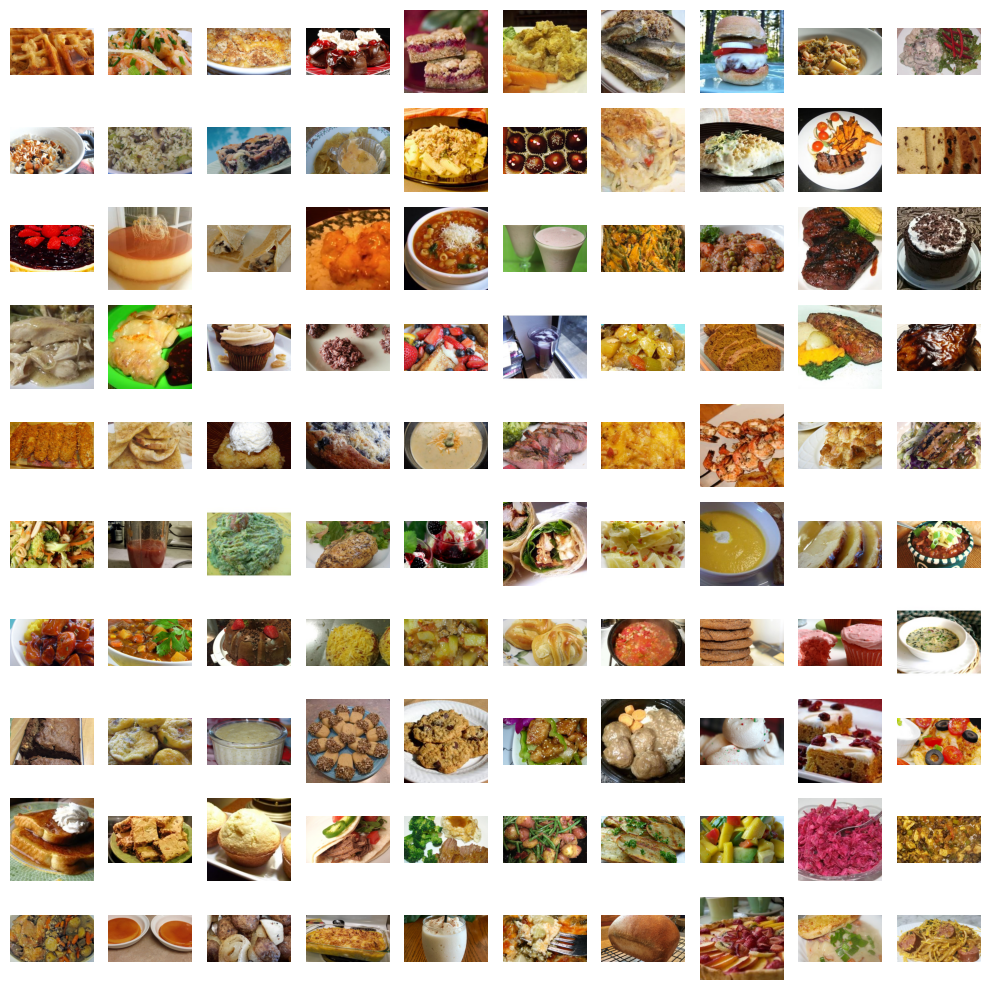

In [260]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import math

print("Number of recipes in the stratified sample: ", sampled_df.shape[0])
# display sampled recipe images
sampled_ids = sampled_df['recipe_id'].tolist()
grid_size = math.ceil(math.sqrt(len(sampled_ids)))  # Change this to fit your needs
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
for sampled_id, ax in zip(sampled_ids, axes.flat):
    display_selected_recipe(sampled_id, ax)
plt.tight_layout()
plt.show()

# Jaccard and Dice

In [261]:
recipeIngredients = sampled_df.set_index('recipe_id')
recipeIngredients = recipeIngredients.drop(columns=['Sampled Ingredient','recipe_name','Sampled Ingredient Name'])
recipeIngredients = recipeIngredients.sort_index()
recipeIngredients.head()

,2,3,6,8,9,10,13,16,18,21,...,6560,7208,7555,7610,8063,8208,8955,10560,12070,12967
recipe_id,,,,,,,,,,,,,,,,,,,,,
6811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6845,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7127,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8025,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
# visualize jaccard similarity between recipes

def compute_jaccard_similarity(feature_matrix):
    recipe_ids = feature_matrix.index
    matrix = feature_matrix.values
    intersection = np.dot(matrix, matrix.T)
    row_sums = intersection.diagonal() #number of ingredients in each recipe
    unions = row_sums[:, None] + row_sums - intersection # 2d array where [i,j] is the size of the union between the ith and jth recipes
    jaccard_similarity = intersection / (unions + 1e-10)
    np.fill_diagonal(jaccard_similarity, 1)
    return jaccard_similarity, recipe_ids

ingr_jaccard_matrix, recipe_ids = compute_jaccard_similarity(recipeIngredients)

def compute_dice_similarity(feature_matrix):
    recipe_ids = feature_matrix.index
    matrix = feature_matrix.values
    intersection = np.dot(matrix, matrix.T)
    row_sums = intersection.diagonal() 
    denominator = row_sums[:, None] + row_sums # |a| + |b|
    dice_coefficient = (2 * intersection) / (denominator + 1e-10)
    np.fill_diagonal(dice_coefficient, 1) 
    return dice_coefficient, recipe_ids

ingr_dice_matrix, recipe_ids = compute_dice_similarity(recipeIngredients)

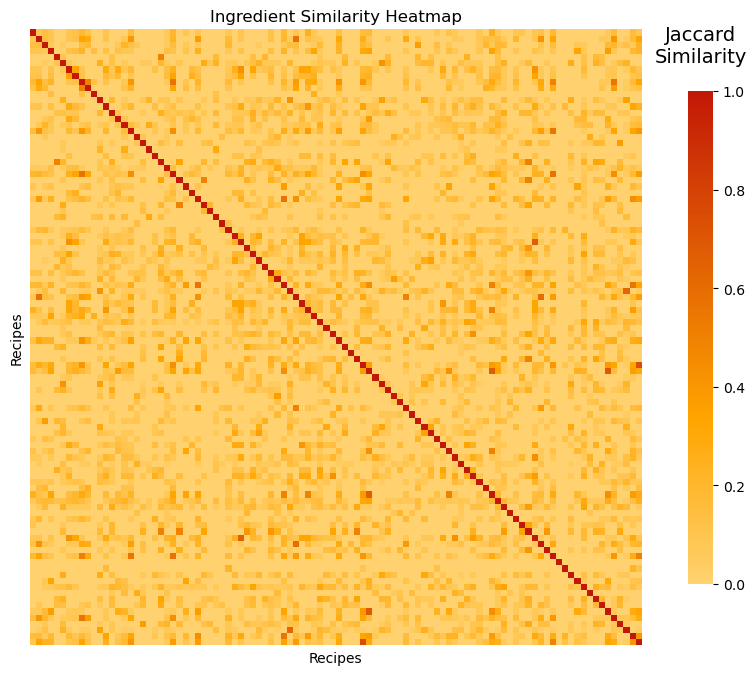

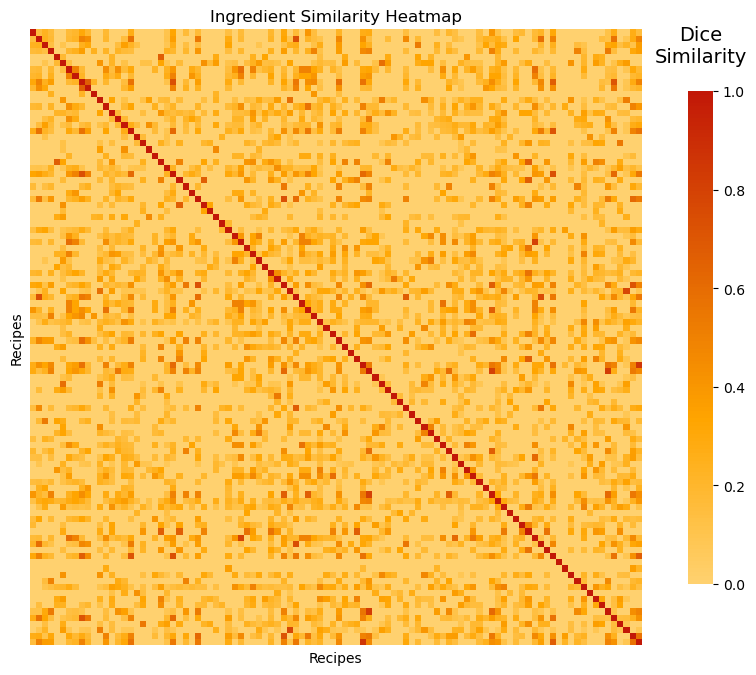

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

base_colors = ['#ffffe0','#ffffe0', 'orange', '#C21807']
cmap = LinearSegmentedColormap.from_list('custom_cmap', base_colors)

# Jaccard Similarity Ingredient Heatmap
plt.figure(figsize=(10, 8))
ax1 = sns.heatmap(ingr_jaccard_matrix, cmap=cmap, center=0, vmax=1, 
                  cbar_kws={'pad': 0.06, 'shrink': 0.8})
ax1.set_title('Ingredient Similarity Heatmap')
ax1.set_xlabel('Recipes')  
ax1.set_ylabel('Recipes')  
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
cbar1 = ax1.collections[0].colorbar
cbar1.ax.yaxis.set_label_position('left')  
cbar1.ax.text(0.5, 1.05, 'Jaccard\nSimilarity', ha='center', va='bottom', fontsize=14, transform=cbar1.ax.transAxes)
plt.show()

# Dice Coefficient Similarity Ingredient Heatmap
plt.figure(figsize=(10, 8))
ax2 = sns.heatmap(ingr_dice_matrix, cmap=cmap, center=0, vmax=1, 
                  cbar_kws={'pad': 0.06, 'shrink': 0.8})
ax2.set_title('Ingredient Similarity Heatmap')
ax2.set_xlabel('Recipes')  
ax2.set_ylabel('Recipes')  
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
cbar2 = ax2.collections[0].colorbar
cbar2.ax.yaxis.set_label_position('left')  
cbar2.ax.text(0.5, 1.05, 'Dice\nSimilarity', ha='center', va='bottom', fontsize=14, transform=cbar2.ax.transAxes)
plt.show()


# Demonstrating significance of novel text-processing algorithm
- compared with traditional tfidf
- demonstrated on stratified sample of recipes (based on ingredient content)

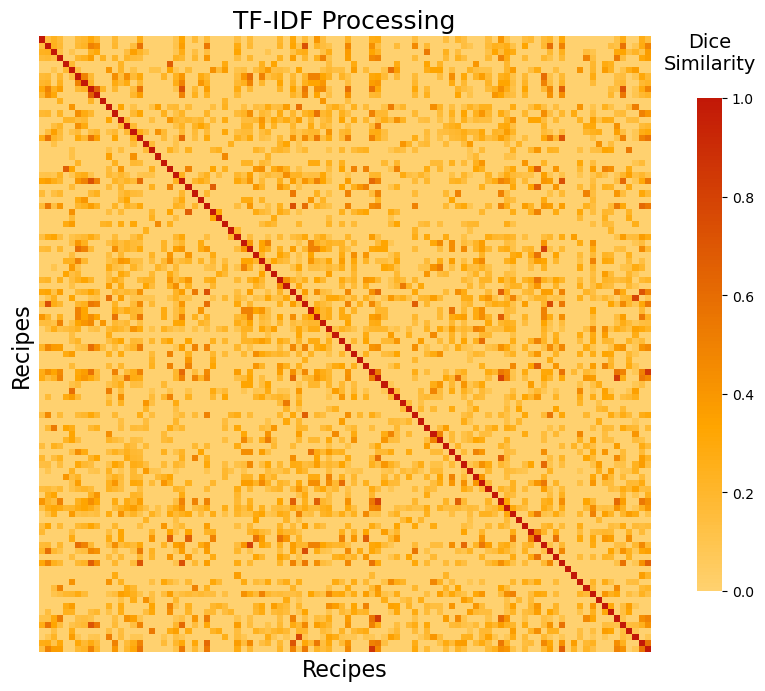

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

base_colors = ['#ffffe0', 
               '#ffffe0', # Light yellow 
               'orange',   # Orange 
               '#C21807']  # Burgundy 

new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_yellow_orange_burgundy", base_colors)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(ingr_dice_matrix, cmap=new_cmap, center=0, vmax=1,
                 cbar_kws={'pad': 0.06, 'shrink': 0.8})

plt.title('Food-IDF Processing', fontsize=18)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.xlabel('Recipes', fontsize=16)
plt.ylabel('Recipes', fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.text(0.5, 1.05, 'Dice\nSimilarity', ha='center', va='bottom', fontsize=14, transform=cbar.ax.transAxes)

plt.show()


# Evaluation - Intra-matrix similarity

 Average pairwise similarity. Computes the similarity between all possible pairs of recipes within the matrix and then averages these values. (ignoring diagonal)

In [265]:
def avg_pairwise_sim(matrix):
    i_upper = np.triu_indices(len(matrix), k=1)
    similarities = matrix[i_upper]
    average_similarity = np.mean(similarities)
    
    return average_similarity

# avg_sim_tfidf = avg_pairwise_sim(ingr_old_dice_matrix)
avg_sim_foodidf = avg_pairwise_sim(ingr_dice_matrix)

# print(f'Average Pairwise Similarity of TFIDF: {avg_sim_tfidf}')
print(f'Average Pairwise Similarity of FoodIDF: {avg_sim_foodidf}')

Average Pairwise Similarity of FoodIDF: 0.09889992593877876


# CONTENT BASED RECOMMENDER

In [266]:
def load_data(file):
    data = np.genfromtxt(file, delimiter=',', dtype=int, skip_header=1)
    rated_recipes = {}
    for row in data:
        user_id, recipe_id, rating = row
        rated_recipes.setdefault(user_id, []).append((recipe_id, rating))
    return rated_recipes

In [267]:
train_data = load_data('reduced_train.csv')
test_data = load_data('reduced_test.csv')

In [268]:
idf = calculate_idf(recipe_ingredient_df_new)
filtered_recipes_df, removed_ingredients = filter_ingredients_by_idf(recipe_ingredient_df_new, idf, 1, 95)
filtered_recipes_df.to_csv('path_to_filtered_csv.csv', index=False)
removed_ingredient_names = [name for name, id_new in name_to_new_id.items() if id_new in removed_ingredients]
print("Names of removed ingredients:", removed_ingredient_names)

Names of removed ingredients: ['bell', 'firm', 'flake', 'iceberg', 'jam', 'maraschino', 'onion', 'pepper', 'portobello', 'rib', 'size', 'smith', 'sodium', 'thai', 'torn']


In [269]:
display(filtered_recipes_df.shape)
display(filtered_recipes_df.head())

(18855, 228)

,recipe_id,2,3,6,8,9,10,13,16,18,...,6560,7208,7555,7610,8063,8208,8955,10560,12070,12967
0,87211,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20453,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22402,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23658,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26668,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [270]:
def get_recipe_similarity(recipe_id, rated_recipes):
    recipe_ingredients = filtered_recipes_df[filtered_recipes_df['recipe_id'] == recipe_id].values[0]
    similarity_dict = {}
    # Iterate over the rated recipes
    for rated_recipe_id, rating in rated_recipes.items():
        # Get the ingredient matrix for the rated recipe
        rated_recipe_ingredients = filtered_recipes_df[filtered_recipes_df['recipe_id'] == rated_recipe_id].values[0]
        # Calculate the Jaccard similarity between the two recipes
        intersection = np.logical_and(recipe_ingredients, rated_recipe_ingredients).sum()
        union = np.logical_or(recipe_ingredients, rated_recipe_ingredients).sum()
        similarity = intersection / union
        # Add the similarity of the rated recipe with the unrated and add this rated recipe to the dictionary (similarity, rating) 
        similarity_dict[rated_recipe_id] = [similarity, rating]
        
    return similarity_dict

In [271]:
def exponential_average(neighbors_dict, exponential_factor):
    # Extract the similarities and ratings from the dictionary
    neighbor_similarities = np.array([value[0] for value in neighbors_dict.values()])
    neighbor_ratings = np.array([value[1] for value in neighbors_dict.values()])
    # Apply exponential transformation
    exponential_similarities = np.power(exponential_factor, neighbor_similarities)
    # Normalize exponential similarities 
    normalized_exponential_similarities = exponential_similarities / np.sum(exponential_similarities)
    if normalized_exponential_similarities.size > 0:
        weighted_ratings = normalized_exponential_similarities * neighbor_ratings
        weighted_average = np.sum(weighted_ratings) / np.sum(normalized_exponential_similarities)
    else:
        weighted_average = 3  # Default/fallback rating
    
    rounded_weighted_average = round(weighted_average)
    return rounded_weighted_average

# Evaluate exponential model

In [272]:
import math
def select_ratings(ratings, percentage):
    num_ratings = len(ratings)
    num_selected = math.ceil(num_ratings * percentage)
    return ratings[:num_selected]

train_100 = {user_id: select_ratings(ratings, 1.0) for user_id, ratings in train_data.items() if len(ratings) > 1 and len(test_data.get(user_id, [])) > 1}
train_80 = {user_id: select_ratings(ratings, 0.8) for user_id, ratings in train_data.items() if len(ratings) > 1 and len(test_data.get(user_id, [])) > 1}
train_60 = {user_id: select_ratings(ratings, 0.6) for user_id, ratings in train_data.items() if len(ratings) > 1 and len(test_data.get(user_id, [])) > 1}
train_40 = {user_id: select_ratings(ratings, 0.4) for user_id, ratings in train_data.items() if len(ratings) > 1 and len(test_data.get(user_id, [])) > 1}
train_20 = {user_id: select_ratings(ratings, 0.2) for user_id, ratings in train_data.items() if len(ratings) > 1 and len(test_data.get(user_id, [])) > 1}

In [273]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

def calculate_user_data(train_data, test_data, user_ids):
    all_predicted_ratings = {}
    all_actual_ratings = {}
    all_rmse = {}
    user_data = []

    # Iterate over all users in the test data
    for user_id in user_ids:
        rated_recipes = train_data.get(user_id, [])
        rated_recipes_dict = {recipe_id: rating for recipe_id, rating in rated_recipes}
        test_rated_recipes = test_data.get(user_id, [])
        test_rated_recipes_dict = {recipe_id: rating for recipe_id, rating in test_rated_recipes}

        predicted_ratings = {}
        for recipe_id, _ in test_rated_recipes:
            similarity_dict = get_recipe_similarity(recipe_id, rated_recipes_dict)
            exponential_average_rating = exponential_average(similarity_dict, 2)
            predicted_ratings[recipe_id] = exponential_average_rating

        # Store the predicted ratings for the user
        all_predicted_ratings[user_id] = predicted_ratings
        all_actual_ratings[user_id] = test_rated_recipes_dict

        # Calculate RMSE for the user
        actual_ratings_list = list(all_actual_ratings[user_id].values())
        predicted_ratings_list = list(all_predicted_ratings[user_id].values())
        
        if actual_ratings_list and predicted_ratings_list:  
            rmse = sqrt(mean_squared_error(actual_ratings_list, predicted_ratings_list))
        else:
            rmse = None  # No RMSE if no ratings are available

        all_rmse[user_id] = rmse
        user_data.append([user_id, rmse, len(rated_recipes), len(test_rated_recipes)])

    user_df = pd.DataFrame(user_data, columns=['user_id', 'rmse', 'rated_recipe_count', 'test_recipe_count'])
    return user_df


# Adaptation of Model in Literature

In [274]:
from sklearn.linear_model import LinearRegression
def train_regression_model(similarity_scores, ratings):
    similarity_scores = np.array(similarity_scores).reshape(-1, 1)
    ratings = np.array(ratings).reshape(-1, 1)
    model = LinearRegression()
    model.fit(similarity_scores, ratings)
    return model


In [275]:
def create_user_profile(rated_recipes, filtered_recipes_df):
    user_profile = np.zeros_like(filtered_recipes_df.iloc[0].values[1:]).astype(float)  # Convert to float array
    for recipe_id, rating in rated_recipes:
        # Get the ingredient vector for the recipe
        recipe_vector = filtered_recipes_df[filtered_recipes_df['recipe_id'] == recipe_id].values[0][1:]
        # Add weighted recipe vector to the user profile
        user_profile += rating * recipe_vector
    # Normalize the user profile
    if np.linalg.norm(user_profile) > 0:
        user_profile /= np.linalg.norm(user_profile)

    return user_profile

In [276]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(filtered_recipes_df, recipe_id, user_profile):
    recipe_vector = filtered_recipes_df[filtered_recipes_df['recipe_id'] == recipe_id].values[0][1:]

    user_profile = user_profile.reshape(1, -1)
    recipe_vector = recipe_vector.reshape(1, -1)

    # Calculate the cosine similarity between the user profile and the unrated recipe
    similarity = cosine_similarity(user_profile, recipe_vector)[0][0]
    return similarity


In [277]:
from sklearn.model_selection import train_test_split
def train_general_model(filtered_recipes_df, data, user_ids):
    all_similarity_scores = []
    all_ratings = []
    for user_id in user_ids:
        rated_recipes = data.get(user_id, [])
        if len(rated_recipes) > 1:
            train_recipes, validation_recipes = train_test_split(rated_recipes, test_size=0.2, random_state=42)
            user_profile = create_user_profile(train_recipes, filtered_recipes_df)
            validation_rated_recipes = {recipe_id: rating for recipe_id, rating in validation_recipes}
            similarity_scores = [get_cosine_similarity(filtered_recipes_df, recipe_id, user_profile) for recipe_id in validation_rated_recipes.keys()]
            all_similarity_scores.extend(similarity_scores)
            all_ratings.extend(validation_rated_recipes.values())

    model = train_regression_model(all_similarity_scores, all_ratings)
    return model


In [278]:
def predict_ratings(filtered_recipes_df, model, rated_data, test_data, user_ids):
    user_data = []
    predicted_ratings = {}
    actual_ratings = {}
    all_rmse = {}
    for user_id in user_ids:
        rated_recipes = rated_data.get(user_id, [])
        unrated_recipes = test_data.get(user_id, [])
        un_rated_recipes = {recipe_id: rating for recipe_id, rating in unrated_recipes}
        user_profile = create_user_profile(rated_recipes, filtered_recipes_df)
        similarity_scores = [get_cosine_similarity(filtered_recipes_df, recipe_id, user_profile) for recipe_id in un_rated_recipes.keys()]
        predicted_ratings[user_id] = model.predict(np.array(similarity_scores).reshape(-1, 1)).flatten()
        test_rated_recipes = test_data.get(user_id, [])
        test_rated_recipes_dict = {recipe_id: rating for recipe_id, rating in test_rated_recipes}
        actual_ratings[user_id] = [test_rated_recipes_dict.get(recipe_id) for recipe_id in un_rated_recipes.keys()]

        if len(actual_ratings[user_id]) and len(predicted_ratings[user_id]):  
            rmse = sqrt(mean_squared_error(actual_ratings[user_id], predicted_ratings[user_id]))
        else:
            rmse = None

        all_rmse[user_id] = rmse
        user_data.append([user_id, rmse, len(rated_recipes), len(unrated_recipes)])

    user_df = pd.DataFrame(user_data, columns=['user_id', 'rmse', 'rated_recipe_count', 'test_recipe_count'])
    return user_df

In [ ]:
model = train_general_model(filtered_recipes_df, train_data, train_data.keys())
benchmark_100_df = predict_ratings(filtered_recipes_df, model, train_data, test_data, train_100.keys())
benchmark_100_rmse = benchmark_100_df['rmse'].mean() 
print(f'100% data input, benchmark RMSE: {benchmark_100_rmse}')
display(benchmark_100_df)

RMSE for benchmark and model at 100% = 0.7420329986834631,0.6744087925118524
RMSE for benchmark and model at 80% = 0.7419068621460312,0.6856915940398349
RMSE for benchmark and model at 60% = 0.7412931188201858,0.6910035253224097
RMSE for benchmark and model at 40% = 0.7400319012754483,0.7191144929862057
RMSE for benchmark and model at 20% = 0.7378051544518759,0.7330876114563102


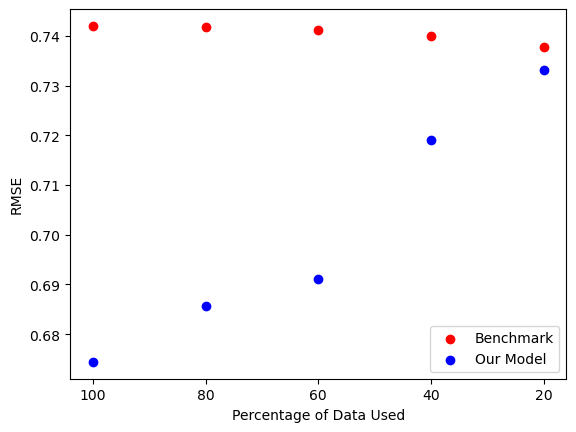

In [ ]:
train_datasets = {
    '100': train_100,
    '80': train_80,
    '60': train_60,
    '40': train_40,
    '20': train_20
}

import matplotlib.pyplot as plt

rmse_values = {}

for percentage, train_data in train_datasets.items():
    data_df = calculate_user_data(train_data, test_data, train_data.keys())
    rmse_data = data_df['rmse'].mean()

    benchmark_df = predict_ratings(filtered_recipes_df, model, train_data, test_data, train_data.keys())
    benchmark_rmse = benchmark_df['rmse'].mean() 

    rmse_values[percentage] = (benchmark_rmse, rmse_data)
    print(f"RMSE for benchmark and model at {percentage}% = {benchmark_rmse},{rmse_data}")

benchmark_rmse_values = [values[0] for values in rmse_values.values()]
our_rmse_values = [values[1] for values in rmse_values.values()]


# Visualize sparsity RMSE results

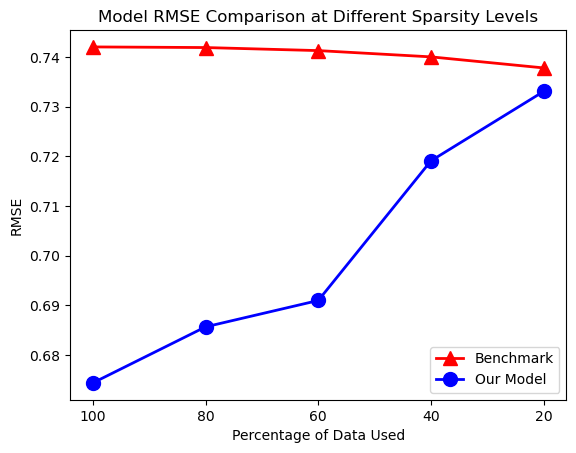

In [ ]:
import matplotlib.pyplot as plt
x_data = list(rmse_values.keys())  
plt.plot(x_data, benchmark_rmse_values, '-r^', label='Benchmark', markersize=10, linewidth=2)
plt.plot(x_data, our_rmse_values, '-bo', label='Our Model', markersize=10, linewidth=2)
plt.title("Model RMSE Comparison at Different Sparsity Levels")
plt.xlabel('Percentage of Data Used')
plt.ylabel('RMSE')
plt.legend()
plt.show()
